In [3]:
from natsort import natsorted
import os
from tqdm import tqdm
import soundfile as sf
import librosa
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from utils import *
import pandas as pd
from torchaudio.models import Emformer
import torch.nn as nn 
import torch.optim as optim

In [4]:
df = {'model': [], 'val loss': []}
for i in list(filter(lambda i: "Emformer" in i, get_files('/data/pitch_estimation'))):
    result = load_pkl(os.path.join(i, 'stats.pkl'))
    df['model'].append(os.path.basename(i))
    df['val loss'].append(min(result['val_loss']))
df = pd.DataFrame(df).sort_values('val loss')
df['model'] = df['model'].apply(lambda x: x.replace('Emformer', '').replace('_', ' '))
df['val loss'] = df['val loss'].apply(lambda x: round(x, 3))
df

,model,val loss
3,MIR1k bs64 gelu,0.911
2,MIR1k bs64,0.922
4,MIR1k bs64 small,0.954
0,MIR1k,0.954
1,MIR1k bs32,0.965
5,MIR1k bs64 small gelu,0.966


In [5]:
B, C, T = 1, 2, 5
C_encoded = 2
data = torch.ones((B, C, T))
prior_info = torch.zeros((B, C_encoded))

result = torch.concatenate((data, prior_info.unsqueeze(-1).expand(-1, -1, T)), dim = 1)
print(result.shape)
result

torch.Size([1, 4, 5])


tensor([[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

In [15]:
# TODO: copy this block for MIR 1k dataset and dataloader. 
# Create a pytorch dataset for MIR 1k.


CENTS_PER_BIN = 20  # cents
MAX_FMAX = 2006.  # hz
PITCH_BINS = 360
SAMPLE_RATE = 16000  # hz
WINDOW_SIZE = 1024

def frequency_to_cents(frequency):
    """Convert frequency in Hz to cents"""
    return 1200 * torch.log2(frequency / 10.)

# We can use this function to quantize the pitch to the nearest bin.
# but 1997 actually corresponds to 31.7hz instead of 32.7 as noted in the paper. 
def cents_to_bins(cents, quantize_fn=torch.floor):
    """Converts cents to pitch bins"""
    bins = (cents - 1997.3794084376191) / CENTS_PER_BIN
    return quantize_fn(bins).int()

def frequency_to_bins(frequency, quantize_fn=torch.floor):
    """Convert frequency in Hz to pitch bins"""
    mask = torch.isclose(frequency, torch.tensor([0.0], dtype = torch.float32))
    result = cents_to_bins(frequency_to_cents(frequency), quantize_fn)
    
    # Pitch label: 0 - 359 
    # 360: unvoiced.
    # Total of 361 bins.
    result[mask] = 360
    return result 


class MIR1kDataset(Dataset):
    def __init__(self, mel_dir, pitch_dir, fids):
        self.mel_dir = mel_dir
        self.pitch_dir = pitch_dir
        
        # File ids.
        fids = read(fids).strip().split('\n')
        
        # Check if all features files exist. 
        self.fids = fids
        for i in fids:
            assert os.path.exists(os.path.join(mel_dir, f"{i}.npy"))
            assert os.path.exists(os.path.join(pitch_dir, f"{i}.npy"))
    def __len__(self):
        return len(self.fids)

    def __getitem__(self, idx):
        fid = self.fids[idx]
        mel = np.load(os.path.join(self.mel_dir, f"{fid}.npy"))
        pitch = np.load(os.path.join(self.pitch_dir, f"{fid}.npy"))
        return mel, pitch

# Create a collate fn that randomly crop the waveform and pitch.
# min_len: 1 sec of mel. max_len: 3sec of mel.
def collate_fn(batch, min_len = 50, max_len = 150):
    mel = [i[0] for i in batch]
    pitch = [i[1] for i in batch]
    
    # Randomly crop the mel and pitch.
    crop_len = random.randint(min_len, max_len)
    min_mel_len = min([i.shape[1] for i in mel])
    
    random_start = random.randint(0, min_mel_len - crop_len)
    
    # (B, C, crop_len)
    mel = torch.stack([torch.tensor(i[:, random_start:random_start + crop_len]) for i in mel]).float()
    
    # (B, crop_len)
    pitch = torch.stack([torch.tensor(i[random_start:random_start + crop_len]) for i in pitch]).float()
    # orig_pitch = pitch.clone()
    
    # Convert pitch to cents.
    pitch = frequency_to_bins(pitch)
    return mel, pitch

def eval_collate_fn(batch):
    mel = [i[0] for i in batch]
    pitch = [i[1] for i in batch]
    
    # Pad the mel and pitch.
    length = torch.tensor([i.shape[1] for i in mel]).long()
    max_len = max([i.shape[1] for i in mel])
    mel = torch.stack([torch.concatenate((torch.tensor(i), torch.zeros((i.shape[0], max_len - i.shape[1]))), dim = 1) for i in mel]).float()
    pitch = torch.stack([torch.concatenate((torch.tensor(i), torch.zeros(max_len - i.shape[0]))) for i in pitch]).float()
    assert mel.shape[-1] == pitch.shape[-1]
    
    pitch = frequency_to_bins(pitch).long()
    return mel, pitch, length


def test_collate_fn(batch):
    mel = [i[0] for i in batch]
    pitch = [i[1] for i in batch]
    
    # Pad the mel and pitch.
    length = torch.tensor([i.shape[1] for i in mel]).long()
    max_len = max([i.shape[1] for i in mel])
    mel = torch.stack([torch.concatenate((torch.tensor(i), torch.zeros((i.shape[0], max_len - i.shape[1]))), dim = 1) for i in mel]).float()
    pitch = torch.stack([torch.concatenate((torch.tensor(i), torch.zeros(max_len - i.shape[0]))) for i in pitch]).float()
    assert mel.shape[-1] == pitch.shape[-1]
    orig_pitch = pitch.clone()
    pitch = frequency_to_bins(pitch).long()
    return mel, pitch, length, orig_pitch


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class Emformer_Classifier(nn.Module):
    def __init__(self, input_dim = 80, num_heads = 4, ffn_dim = 512, num_layers = 9, segment_length = 8, 
                    right_context_length=2, left_context_length=2, num_classes = 361, activation='relu'):
        super(Emformer_Classifier, self).__init__()
        self.emformer = Emformer(input_dim=input_dim, num_heads=num_heads, ffn_dim=ffn_dim, num_layers=num_layers, 
                                segment_length=segment_length, right_context_length=right_context_length, 
                                left_context_length=left_context_length, activation=activation)
        
        self.linear = nn.Linear(input_dim, num_classes)
        self.right_context_length = self.emformer.right_context_length
    def forward(self, x, length):
        outputs, length = self.emformer(x, length)
        outputs = self.linear(outputs)
        return outputs, length

def plot_loss(directory):
    result = load_pkl(os.path.join(directory, "stats.pkl"))
    plt.plot(result['train_loss'], label='train_loss')
    plt.plot(result['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()




# Train dataset and dataloader.
train_dataset = MIR1kDataset(mel_dir='/data/pitch_estimation/dataset/MIR-1K/mel_spec_both', 
                             pitch_dir='/data/pitch_estimation/dataset/MIR-1K/pitch_50', 
                             fids='/data/pitch_estimation/dataset/MIR-1K/train.txt')
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=eval_collate_fn)


# Val dataset and dataloader.
val_dataset = MIR1kDataset(mel_dir='/data/pitch_estimation/dataset/MIR-1K/mel_spec_both',
                           pitch_dir='/data/pitch_estimation/dataset/MIR-1K/pitch_50',
                           fids='/data/pitch_estimation/dataset/MIR-1K/val.txt')
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=eval_collate_fn)


# Test dataset and dataloader.
test_dataset = MIR1kDataset(mel_dir='/data/pitch_estimation/dataset/MIR-1K/mel_spec_both',
                            pitch_dir='/data/pitch_estimation/dataset/MIR-1K/pitch_50',
                            fids='/data/pitch_estimation/dataset/MIR-1K/test.txt')
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=test_collate_fn)


In [16]:



def test_model(model, dataset, gpu_number = 0):
    device = torch.device('cuda:{}'.format(gpu_number))
    model.eval()
    total_loss = 0
    num_left = model.emformer.left_context_length
    num_right = model.emformer.right_context_length
    
    
    with torch.no_grad():
        for mel, pitch in tqdm(dataset, total = len(dataset)):
            
            # (1, C, T)
            mel = torch.tensor(mel).unsqueeze(0).float().to(device)
            pitch = torch.tensor(pitch).unsqueeze(0).long().to(device)
            
            # length = segment length + right context length.
            
            
    return total_loss / len(dataset)

In [17]:
import scipy 
def dither(cents):
    """Dither the predicted pitch in cents to remove quantization error"""
    noise = scipy.stats.triang.rvs(c=0.5,
                                   loc=-CENTS_PER_BIN,
                                   scale=2 * CENTS_PER_BIN,
                                   size=cents.size())
    return cents + cents.new_tensor(noise)

def bins_to_cents(bins):
    """Converts pitch bins to cents"""
    cents = CENTS_PER_BIN * bins + 1997.3794084376191

    # Trade quantization error for noise
    return dither(cents)

In [21]:
test = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).long()
print(bins_to_cents(test))

tensor([2001.5323, 2022.4982, 2043.3462, 2052.5425, 2060.4128, 2099.7305,
        2109.4902, 2133.5608, 2171.7561, 2186.1201])


In [61]:
def offline_decode(model, dataloader, gpu_number = 6):
    device = torch.device('cuda:{}'.format(gpu_number))
    model.eval()
    
    total_correct = 0
    total_correct_silence = 0
    total = 0
    total_silence = 0
    with torch.no_grad():
        for mel, pitch, length, pitch_hz in tqdm(dataloader, total = len(dataloader)):
            mel = mel.to(device).transpose(1, 2)
            pitch = pitch.to(device)
            pitch_hz = pitch_hz.to(device)
            length = length.to(device)
            output, length = model(mel, length)
            pred  = output.argmax(-1)
            
            # (1, T) => (T)
            pred = pred.squeeze(0)
            pitch = pitch.squeeze(0)[:pred.size(0)]
            
            pred_cents = bins_to_cents(pred)
            mask = pitch != 360
            target_cents = bins_to_cents(pitch)
            
            # Accurate if within 50 cents.
            acc = torch.abs(pred_cents[mask] - target_cents[mask]) <= 50
            total_correct += acc.sum().item()
            total+= acc.numel()
            
            acc_silence = pred[~mask] == 360
            total_correct_silence += acc_silence.sum().item()
            total_silence += acc_silence.numel()
    
    return total_correct / total, total_correct_silence / total_silence

In [62]:
model = Emformer_Classifier(input_dim=256, activation = 'gelu').to('cuda:5')
print(f"Number of parameters: {count_params(model)}")

ckpt = torch.load('/data/pitch_estimation/Emformer_MIR1k_bs64_gelu/best_val_ckpt.pth')
model.load_state_dict(ckpt['model_ckpt'])

Number of parameters: 4841321


/tmp/ipykernel_2767140/2407985445.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('/data/pitch_estimation/Emformer_MIR1k_bs64_gelu/best_val_ckpt.pth')


<All keys matched successfully>

In [63]:
offline_decode(model, test_dataloader, gpu_number = 5)

100%|██████████| 100/100 [00:02<00:00, 46.47it/s]


(0.8134297751761679, 0.8239657880956537)

In [51]:
result

0.5851250032654981

In [24]:
ckpt.keys()

dict_keys(['model_ckpt', 'optimizer', 'epoch', 'best_val_loss'])

In [ ]:
train_dataset[0][0].shape

In [27]:
def train_model(model, train_loader, val_loader, num_epochs, num_eval_epoch, 
                criterion=None, optimizer=None, scheduler=None, save_dir = "", gpu_number = 6):
    # If no criterion is provided, use cross-entropy loss
    mkdir(save_dir)
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    device = torch.device(f'cuda:{gpu_number}' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Move the model to the appropriate device
    model.to(device)
    
    # If no optimizer is provided, use Adam
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    
    train_loss = []
    val_loss = []
    val_acc =[]
    
    # Loop over the dataset multiple times
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Iterate over data.
        for index, (inputs, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            inputs, labels = inputs.to(device), labels.to(device).long()
            length = torch.tensor([i.shape[-1] for i in inputs]).long() - model.right_context_length
            length = length.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            # Emformer needs BTC. 
            outputs, length = model(inputs.transpose(1, -1), length)
            
            # Only calculate on the valid outputs.
            # print(outputs.shape, labels.shape)
            loss = criterion(outputs.transpose(1, -1), labels[:, :outputs.shape[1]])
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss_epoch = running_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss_epoch}')
        train_loss.append(train_loss_epoch)
        
        # Step the scheduler if provided
        if scheduler is not None:
            scheduler.step()
        
        # Evaluate the model every num_eval_epoch epochs
        if (epoch + 1) % num_eval_epoch == 0:
            result = evaluate_model(model, val_loader, criterion, device)
            print(f'Epoch: {epoch} Validation Loss: {result["val_loss"]}, Validation Accuracy: {result["val_acc"]}')
            val_loss.append(result["val_loss"])
            val_acc.append(result["val_acc"])
            
            if result["val_loss"] < best_val_loss:
                best_val_loss = result["val_loss"]
                torch.save({'model_ckpt': model.state_dict(),
                            "optimizer": optimizer.state_dict(),
                            "epoch": epoch,
                            "best_val_loss": best_val_loss,
                            }, os.path.join(save_dir, 'best_val_ckpt.pth'))
                print(f"Best model saved at epoch {epoch}, val loss: {best_val_loss}")
    stats = {'train_loss': train_loss, 'val_loss': val_loss, 'val_acc': val_acc}
    save_pkl(stats, os.path.join(save_dir, 'stats.pkl'))

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        val_loss = 0.0
        count = 0
        for _, (inputs, labels, length) in tqdm(enumerate(dataloader), total = len(dataloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            length = length.to(device)
            outputs, length = model(inputs.transpose(1, -1), length - model.right_context_length)
            for i in range(len(length)):
                
                # (B, C, T)
                curr_output = outputs[i, :length[i]].transpose(0, 1).unsqueeze(0)
                
                #(B, T)
                curr_label = labels[i, :length[i]].unsqueeze(0)


                val_loss += criterion(curr_output, curr_label).item()
                count += 1
            # _, predicted = torch.max(outputs.data, 1)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()
    
    # accuracy = 100 * correct / total
    val_loss /= count
    return {'val_loss': val_loss, 'val_acc': None}

Number of parameters: 4841321
Using device: cuda:5


100%|██████████| 14/14 [00:01<00:00,  7.54it/s]


Epoch 1/100, Loss: 3.2090356860842024


100%|██████████| 13/13 [00:00<00:00, 38.24it/s]


Epoch: 0 Validation Loss: 1.8497089958190918, Validation Accuracy: None
Best model saved at epoch 0, val loss: 1.8497089958190918


100%|██████████| 14/14 [00:01<00:00, 11.07it/s]


Epoch 2/100, Loss: 1.7969949415751867


100%|██████████| 13/13 [00:00<00:00, 38.22it/s]


Epoch: 1 Validation Loss: 1.5416078615188598, Validation Accuracy: None
Best model saved at epoch 1, val loss: 1.5416078615188598


100%|██████████| 14/14 [00:01<00:00, 11.58it/s]


Epoch 3/100, Loss: 1.5522412742887224


100%|██████████| 13/13 [00:00<00:00, 32.20it/s]


Epoch: 2 Validation Loss: 1.374702854156494, Validation Accuracy: None
Best model saved at epoch 2, val loss: 1.374702854156494


100%|██████████| 14/14 [00:01<00:00, 12.03it/s]


Epoch 4/100, Loss: 1.3895126496042525


100%|██████████| 13/13 [00:00<00:00, 34.92it/s]


Epoch: 3 Validation Loss: 1.348080929517746, Validation Accuracy: None
Best model saved at epoch 3, val loss: 1.348080929517746


100%|██████████| 14/14 [00:01<00:00, 10.47it/s]


Epoch 5/100, Loss: 1.328464116368975


100%|██████████| 13/13 [00:00<00:00, 39.97it/s]


Epoch: 4 Validation Loss: 1.2752519929409027, Validation Accuracy: None
Best model saved at epoch 4, val loss: 1.2752519929409027


100%|██████████| 14/14 [00:01<00:00, 10.18it/s]


Epoch 6/100, Loss: 1.2877262149538313


100%|██████████| 13/13 [00:00<00:00, 34.52it/s]


Epoch: 5 Validation Loss: 1.2701306945085526, Validation Accuracy: None
Best model saved at epoch 5, val loss: 1.2701306945085526


100%|██████████| 14/14 [00:01<00:00, 10.80it/s]


Epoch 7/100, Loss: 1.2870338474001204


100%|██████████| 13/13 [00:00<00:00, 39.99it/s]


Epoch: 6 Validation Loss: 1.2010751444101333, Validation Accuracy: None
Best model saved at epoch 6, val loss: 1.2010751444101333


100%|██████████| 14/14 [00:01<00:00, 11.36it/s]


Epoch 8/100, Loss: 1.2013132997921534


100%|██████████| 13/13 [00:00<00:00, 33.76it/s]


Epoch: 7 Validation Loss: 1.1684988611936569, Validation Accuracy: None
Best model saved at epoch 7, val loss: 1.1684988611936569


100%|██████████| 14/14 [00:01<00:00, 11.46it/s]


Epoch 9/100, Loss: 1.1561077407428197


100%|██████████| 13/13 [00:00<00:00, 39.63it/s]


Epoch: 8 Validation Loss: 1.1865622735023498, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.84it/s]


Epoch 10/100, Loss: 1.1260463084493364


100%|██████████| 13/13 [00:00<00:00, 30.48it/s]


Epoch: 9 Validation Loss: 1.1504323905706406, Validation Accuracy: None
Best model saved at epoch 9, val loss: 1.1504323905706406


100%|██████████| 14/14 [00:01<00:00,  9.51it/s]


Epoch 11/100, Loss: 1.1065066925116949


100%|██████████| 13/13 [00:00<00:00, 31.94it/s]


Epoch: 10 Validation Loss: 1.1852278780937195, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.72it/s]


Epoch 12/100, Loss: 1.1107538938522339


100%|██████████| 13/13 [00:00<00:00, 38.34it/s]


Epoch: 11 Validation Loss: 1.2328254503011704, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.35it/s]


Epoch 13/100, Loss: 1.083391445023673


100%|██████████| 13/13 [00:00<00:00, 35.68it/s]


Epoch: 12 Validation Loss: 1.1173977166414262, Validation Accuracy: None
Best model saved at epoch 12, val loss: 1.1173977166414262


100%|██████████| 14/14 [00:01<00:00,  9.83it/s]


Epoch 14/100, Loss: 1.066922583750316


100%|██████████| 13/13 [00:00<00:00, 33.51it/s]


Epoch: 13 Validation Loss: 1.0853055495023727, Validation Accuracy: None
Best model saved at epoch 13, val loss: 1.0853055495023727


100%|██████████| 14/14 [00:01<00:00, 11.80it/s]


Epoch 15/100, Loss: 1.0084721616336279


100%|██████████| 13/13 [00:00<00:00, 31.94it/s]


Epoch: 14 Validation Loss: 1.172931697368622, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.11it/s]


Epoch 16/100, Loss: 0.9763845801353455


100%|██████████| 13/13 [00:00<00:00, 38.21it/s]


Epoch: 15 Validation Loss: 1.0681278663873672, Validation Accuracy: None
Best model saved at epoch 15, val loss: 1.0681278663873672


100%|██████████| 14/14 [00:01<00:00,  9.63it/s]


Epoch 17/100, Loss: 0.9830618415560041


100%|██████████| 13/13 [00:00<00:00, 33.94it/s]


Epoch: 16 Validation Loss: 1.0551852452754975, Validation Accuracy: None
Best model saved at epoch 16, val loss: 1.0551852452754975


100%|██████████| 14/14 [00:01<00:00, 11.29it/s]


Epoch 18/100, Loss: 1.0025415803704942


100%|██████████| 13/13 [00:00<00:00, 38.55it/s]


Epoch: 17 Validation Loss: 1.1294701886177063, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.27it/s]


Epoch 19/100, Loss: 0.9729606253760201


100%|██████████| 13/13 [00:00<00:00, 38.72it/s]


Epoch: 18 Validation Loss: 1.0185568821430206, Validation Accuracy: None
Best model saved at epoch 18, val loss: 1.0185568821430206


100%|██████████| 14/14 [00:01<00:00, 11.98it/s]


Epoch 20/100, Loss: 0.9343655960900443


100%|██████████| 13/13 [00:00<00:00, 38.83it/s]


Epoch: 19 Validation Loss: 1.0369882732629776, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.72it/s]


Epoch 21/100, Loss: 0.8672236757619041


100%|██████████| 13/13 [00:00<00:00, 37.07it/s]


Epoch: 20 Validation Loss: 0.9779780441522599, Validation Accuracy: None
Best model saved at epoch 20, val loss: 0.9779780441522599


100%|██████████| 14/14 [00:01<00:00, 12.40it/s]


Epoch 22/100, Loss: 0.8283796736172268


100%|██████████| 13/13 [00:00<00:00, 38.62it/s]


Epoch: 21 Validation Loss: 0.964305072426796, Validation Accuracy: None
Best model saved at epoch 21, val loss: 0.964305072426796


100%|██████████| 14/14 [00:01<00:00,  9.77it/s]


Epoch 23/100, Loss: 0.8137222230434418


100%|██████████| 13/13 [00:00<00:00, 36.58it/s]


Epoch: 22 Validation Loss: 0.971220406293869, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.59it/s]


Epoch 24/100, Loss: 0.7834315342562539


100%|██████████| 13/13 [00:00<00:00, 38.51it/s]


Epoch: 23 Validation Loss: 0.98119131565094, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.12it/s]


Epoch 25/100, Loss: 0.7459413962704795


100%|██████████| 13/13 [00:00<00:00, 34.13it/s]


Epoch: 24 Validation Loss: 0.9707394301891327, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.15it/s]


Epoch 26/100, Loss: 0.7902033116136279


100%|██████████| 13/13 [00:00<00:00, 41.15it/s]


Epoch: 25 Validation Loss: 0.9576972082257271, Validation Accuracy: None
Best model saved at epoch 25, val loss: 0.9576972082257271


100%|██████████| 14/14 [00:01<00:00, 10.35it/s]


Epoch 27/100, Loss: 0.7638130358287266


100%|██████████| 13/13 [00:00<00:00, 41.24it/s]


Epoch: 26 Validation Loss: 0.9483930343389511, Validation Accuracy: None
Best model saved at epoch 26, val loss: 0.9483930343389511


100%|██████████| 14/14 [00:01<00:00, 11.13it/s]


Epoch 28/100, Loss: 0.7582186247621264


100%|██████████| 13/13 [00:00<00:00, 41.18it/s]


Epoch: 27 Validation Loss: 0.9650522565841675, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.20it/s]


Epoch 29/100, Loss: 0.7507382461002895


100%|██████████| 13/13 [00:00<00:00, 41.58it/s]


Epoch: 28 Validation Loss: 0.9887822633981704, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.65it/s]


Epoch 30/100, Loss: 0.7225856184959412


100%|██████████| 13/13 [00:00<00:00, 40.84it/s]


Epoch: 29 Validation Loss: 0.9774384334683418, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.68it/s]


Epoch 31/100, Loss: 0.7101900960717883


100%|██████████| 13/13 [00:00<00:00, 41.25it/s]


Epoch: 30 Validation Loss: 0.9282812514901161, Validation Accuracy: None
Best model saved at epoch 30, val loss: 0.9282812514901161


100%|██████████| 14/14 [00:01<00:00, 10.09it/s]


Epoch 32/100, Loss: 0.6626643581049783


100%|██████████| 13/13 [00:00<00:00, 41.40it/s]


Epoch: 31 Validation Loss: 0.9354379925131798, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.17it/s]


Epoch 33/100, Loss: 0.6470413846629006


100%|██████████| 13/13 [00:00<00:00, 28.16it/s]


Epoch: 32 Validation Loss: 0.938995501101017, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.06it/s]


Epoch 34/100, Loss: 0.6377489864826202


100%|██████████| 13/13 [00:00<00:00, 37.58it/s]


Epoch: 33 Validation Loss: 0.9350460600852967, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.06it/s]


Epoch 35/100, Loss: 0.61712546646595


100%|██████████| 13/13 [00:00<00:00, 35.21it/s]


Epoch: 34 Validation Loss: 0.9325140354037285, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.82it/s]


Epoch 36/100, Loss: 0.6496459969452449


100%|██████████| 13/13 [00:00<00:00, 37.65it/s]


Epoch: 35 Validation Loss: 0.9354162579774856, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.66it/s]


Epoch 37/100, Loss: 0.6722080835274288


100%|██████████| 13/13 [00:00<00:00, 37.61it/s]


Epoch: 36 Validation Loss: 0.9391093680262566, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.63it/s]


Epoch 38/100, Loss: 0.6309862732887268


100%|██████████| 13/13 [00:00<00:00, 34.60it/s]


Epoch: 37 Validation Loss: 0.9311991050839424, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.67it/s]


Epoch 39/100, Loss: 0.6119043018136706


100%|██████████| 13/13 [00:00<00:00, 37.35it/s]


Epoch: 38 Validation Loss: 0.9187913680076599, Validation Accuracy: None
Best model saved at epoch 38, val loss: 0.9187913680076599


100%|██████████| 14/14 [00:01<00:00, 10.81it/s]


Epoch 40/100, Loss: 0.5984043734414237


100%|██████████| 13/13 [00:00<00:00, 38.14it/s]


Epoch: 39 Validation Loss: 0.9426272714138031, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.32it/s]


Epoch 41/100, Loss: 0.5961784209523883


100%|██████████| 13/13 [00:00<00:00, 37.52it/s]


Epoch: 40 Validation Loss: 0.9306348502635956, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.60it/s]


Epoch 42/100, Loss: 0.5996399308953967


100%|██████████| 13/13 [00:00<00:00, 37.79it/s]


Epoch: 41 Validation Loss: 0.9339281618595123, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.37it/s]


Epoch 43/100, Loss: 0.5794159237827573


100%|██████████| 13/13 [00:00<00:00, 37.88it/s]


Epoch: 42 Validation Loss: 0.9254982656240464, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.02it/s]


Epoch 44/100, Loss: 0.5595788019044059


100%|██████████| 13/13 [00:00<00:00, 37.71it/s]


Epoch: 43 Validation Loss: 0.9236951044201851, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.01it/s]


Epoch 45/100, Loss: 0.6002374759742192


100%|██████████| 13/13 [00:00<00:00, 36.30it/s]


Epoch: 44 Validation Loss: 0.9234485760331154, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.96it/s]


Epoch 46/100, Loss: 0.5652129394667489


100%|██████████| 13/13 [00:00<00:00, 37.74it/s]


Epoch: 45 Validation Loss: 0.9379662576317788, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.91it/s]


Epoch 47/100, Loss: 0.5737899712153843


100%|██████████| 13/13 [00:00<00:00, 37.56it/s]


Epoch: 46 Validation Loss: 0.934786936044693, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.16it/s]


Epoch 48/100, Loss: 0.5655165570122855


100%|██████████| 13/13 [00:00<00:00, 38.69it/s]


Epoch: 47 Validation Loss: 0.9444929686188698, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.61it/s]


Epoch 49/100, Loss: 0.5800524396555764


100%|██████████| 13/13 [00:00<00:00, 40.18it/s]


Epoch: 48 Validation Loss: 0.9426163077354431, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.99it/s]


Epoch 50/100, Loss: 0.5582258850336075


100%|██████████| 13/13 [00:00<00:00, 28.69it/s]


Epoch: 49 Validation Loss: 0.9369168570637703, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.63it/s]


Epoch 51/100, Loss: 0.5604407319000789


100%|██████████| 13/13 [00:00<00:00, 36.22it/s]


Epoch: 50 Validation Loss: 0.9174219840764999, Validation Accuracy: None
Best model saved at epoch 50, val loss: 0.9174219840764999


100%|██████████| 14/14 [00:01<00:00, 10.02it/s]


Epoch 52/100, Loss: 0.5519500459943499


100%|██████████| 13/13 [00:00<00:00, 41.66it/s]


Epoch: 51 Validation Loss: 0.9351709613204002, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.39it/s]


Epoch 53/100, Loss: 0.5565498322248459


100%|██████████| 13/13 [00:00<00:00, 42.09it/s]


Epoch: 52 Validation Loss: 0.9317992025613785, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.84it/s]


Epoch 54/100, Loss: 0.574529379606247


100%|██████████| 13/13 [00:00<00:00, 41.82it/s]


Epoch: 53 Validation Loss: 0.9350921866297722, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.80it/s]


Epoch 55/100, Loss: 0.5407080692904336


100%|██████████| 13/13 [00:00<00:00, 41.73it/s]


Epoch: 54 Validation Loss: 0.9295223331451417, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.55it/s]


Epoch 56/100, Loss: 0.5416163504123688


100%|██████████| 13/13 [00:00<00:00, 42.00it/s]


Epoch: 55 Validation Loss: 0.9347326129674911, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.94it/s]


Epoch 57/100, Loss: 0.5612754906926837


100%|██████████| 13/13 [00:00<00:00, 41.56it/s]


Epoch: 56 Validation Loss: 0.9318006417155266, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.74it/s]


Epoch 58/100, Loss: 0.5492812373808452


100%|██████████| 13/13 [00:00<00:00, 41.73it/s]


Epoch: 57 Validation Loss: 0.946649871468544, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.38it/s]


Epoch 59/100, Loss: 0.5697102823427745


100%|██████████| 13/13 [00:00<00:00, 41.48it/s]


Epoch: 58 Validation Loss: 0.9343297553062438, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.06it/s]


Epoch 60/100, Loss: 0.5460242586476463


100%|██████████| 13/13 [00:00<00:00, 41.61it/s]


Epoch: 59 Validation Loss: 0.9333951884508133, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.26it/s]


Epoch 61/100, Loss: 0.5257889692272458


100%|██████████| 13/13 [00:00<00:00, 41.67it/s]


Epoch: 60 Validation Loss: 0.9400884291529655, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.98it/s]


Epoch 62/100, Loss: 0.5121272844927651


100%|██████████| 13/13 [00:00<00:00, 41.44it/s]


Epoch: 61 Validation Loss: 0.9333284783363343, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.00it/s]


Epoch 63/100, Loss: 0.5330773975167956


100%|██████████| 13/13 [00:00<00:00, 41.47it/s]


Epoch: 62 Validation Loss: 0.9284581777453422, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.99it/s]


Epoch 64/100, Loss: 0.5093394879783902


100%|██████████| 13/13 [00:00<00:00, 41.59it/s]


Epoch: 63 Validation Loss: 0.9447546154260635, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.87it/s]


Epoch 65/100, Loss: 0.5033621383564812


100%|██████████| 13/13 [00:00<00:00, 39.85it/s]


Epoch: 64 Validation Loss: 0.9392196694016457, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.88it/s]


Epoch 66/100, Loss: 0.5186715871095657


100%|██████████| 13/13 [00:00<00:00, 39.82it/s]


Epoch: 65 Validation Loss: 0.9392809692025185, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.07it/s]


Epoch 67/100, Loss: 0.5160253047943115


100%|██████████| 13/13 [00:00<00:00, 33.15it/s]


Epoch: 66 Validation Loss: 0.9389716047048569, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.52it/s]


Epoch 68/100, Loss: 0.5015259853431157


100%|██████████| 13/13 [00:00<00:00, 38.88it/s]


Epoch: 67 Validation Loss: 0.9493257656693459, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.98it/s]


Epoch 69/100, Loss: 0.5172213699136462


100%|██████████| 13/13 [00:00<00:00, 38.64it/s]


Epoch: 68 Validation Loss: 0.9342220455408097, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.55it/s]


Epoch 70/100, Loss: 0.5169743874243328


100%|██████████| 13/13 [00:00<00:00, 38.71it/s]


Epoch: 69 Validation Loss: 0.9614602217078209, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.47it/s]


Epoch 71/100, Loss: 0.529895788856915


100%|██████████| 13/13 [00:00<00:00, 38.89it/s]


Epoch: 70 Validation Loss: 0.9467747223377228, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.66it/s]


Epoch 72/100, Loss: 0.5140132201569421


100%|██████████| 13/13 [00:00<00:00, 38.90it/s]


Epoch: 71 Validation Loss: 0.9511829981207848, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.58it/s]


Epoch 73/100, Loss: 0.5277968198060989


100%|██████████| 13/13 [00:00<00:00, 38.76it/s]


Epoch: 72 Validation Loss: 0.9458354103565216, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.02it/s]


Epoch 74/100, Loss: 0.4992537115301405


100%|██████████| 13/13 [00:00<00:00, 38.92it/s]


Epoch: 73 Validation Loss: 0.9607998362183571, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.13it/s]


Epoch 75/100, Loss: 0.48742654493876864


100%|██████████| 13/13 [00:00<00:00, 38.77it/s]


Epoch: 74 Validation Loss: 0.9492366543412208, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.44it/s]


Epoch 76/100, Loss: 0.4762095170361655


100%|██████████| 13/13 [00:00<00:00, 38.79it/s]


Epoch: 75 Validation Loss: 0.9805721744894982, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.00it/s]


Epoch 77/100, Loss: 0.5152203121355602


100%|██████████| 13/13 [00:00<00:00, 38.83it/s]


Epoch: 76 Validation Loss: 0.9523661145567894, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.16it/s]


Epoch 78/100, Loss: 0.49157980935914175


100%|██████████| 13/13 [00:00<00:00, 39.26it/s]


Epoch: 77 Validation Loss: 0.9570310151576996, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.90it/s]


Epoch 79/100, Loss: 0.47869808759008137


100%|██████████| 13/13 [00:00<00:00, 39.33it/s]


Epoch: 78 Validation Loss: 0.9685679662227631, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.27it/s]


Epoch 80/100, Loss: 0.4979697508471353


100%|██████████| 13/13 [00:00<00:00, 35.52it/s]


Epoch: 79 Validation Loss: 0.9586964774131775, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.60it/s]


Epoch 81/100, Loss: 0.4979846030473709


100%|██████████| 13/13 [00:00<00:00, 33.75it/s]


Epoch: 80 Validation Loss: 0.9530582609772682, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.86it/s]


Epoch 82/100, Loss: 0.47892515787056517


100%|██████████| 13/13 [00:00<00:00, 39.44it/s]


Epoch: 81 Validation Loss: 0.9780015206336975, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.51it/s]


Epoch 83/100, Loss: 0.46179566851684023


100%|██████████| 13/13 [00:00<00:00, 39.09it/s]


Epoch: 82 Validation Loss: 0.9647862455248832, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.76it/s]


Epoch 84/100, Loss: 0.46984622946807314


100%|██████████| 13/13 [00:00<00:00, 38.67it/s]


Epoch: 83 Validation Loss: 0.9788117095828056, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.35it/s]


Epoch 85/100, Loss: 0.4756377637386322


100%|██████████| 13/13 [00:00<00:00, 39.02it/s]


Epoch: 84 Validation Loss: 0.9719686535000801, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.32it/s]


Epoch 86/100, Loss: 0.45952826738357544


100%|██████████| 13/13 [00:00<00:00, 39.00it/s]


Epoch: 85 Validation Loss: 0.9747551059722901, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.56it/s]


Epoch 87/100, Loss: 0.49909746434007374


100%|██████████| 13/13 [00:00<00:00, 38.95it/s]


Epoch: 86 Validation Loss: 0.9829355177283287, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.97it/s]


Epoch 88/100, Loss: 0.45037672349384855


100%|██████████| 13/13 [00:00<00:00, 39.01it/s]


Epoch: 87 Validation Loss: 0.9898185408115387, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.93it/s]


Epoch 89/100, Loss: 0.46464393607207705


100%|██████████| 13/13 [00:00<00:00, 38.34it/s]


Epoch: 88 Validation Loss: 0.9794264790415764, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.56it/s]


Epoch 90/100, Loss: 0.4474373779126576


100%|██████████| 13/13 [00:00<00:00, 32.81it/s]


Epoch: 89 Validation Loss: 0.9945247501134873, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.66it/s]


Epoch 91/100, Loss: 0.43898780218192507


100%|██████████| 13/13 [00:00<00:00, 39.31it/s]


Epoch: 90 Validation Loss: 0.9800853008031845, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.08it/s]


Epoch 92/100, Loss: 0.4166101579155241


100%|██████████| 13/13 [00:00<00:00, 39.33it/s]


Epoch: 91 Validation Loss: 0.9957272234559059, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.03it/s]


Epoch 93/100, Loss: 0.43140370718070437


100%|██████████| 13/13 [00:00<00:00, 39.27it/s]


Epoch: 92 Validation Loss: 0.9991288867592811, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.83it/s]


Epoch 94/100, Loss: 0.42291666141578127


100%|██████████| 13/13 [00:00<00:00, 35.50it/s]


Epoch: 93 Validation Loss: 1.000683824121952, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.46it/s]


Epoch 95/100, Loss: 0.432482864175524


100%|██████████| 13/13 [00:00<00:00, 39.11it/s]


Epoch: 94 Validation Loss: 0.986030505001545, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.71it/s]


Epoch 96/100, Loss: 0.4285922774246761


100%|██████████| 13/13 [00:00<00:00, 38.98it/s]


Epoch: 95 Validation Loss: 0.9857623663544655, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.06it/s]


Epoch 97/100, Loss: 0.4651097570146833


100%|██████████| 13/13 [00:00<00:00, 38.82it/s]


Epoch: 96 Validation Loss: 0.9990523910522461, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.66it/s]


Epoch 98/100, Loss: 0.4382899211985724


100%|██████████| 13/13 [00:00<00:00, 38.97it/s]


Epoch: 97 Validation Loss: 0.996492480635643, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.37it/s]


Epoch 99/100, Loss: 0.42240630090236664


100%|██████████| 13/13 [00:00<00:00, 38.11it/s]


Epoch: 98 Validation Loss: 0.9781013137102127, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.58it/s]


Epoch 100/100, Loss: 0.43469832837581635


100%|██████████| 13/13 [00:00<00:00, 39.19it/s]


Epoch: 99 Validation Loss: 0.9901150906085968, Validation Accuracy: None


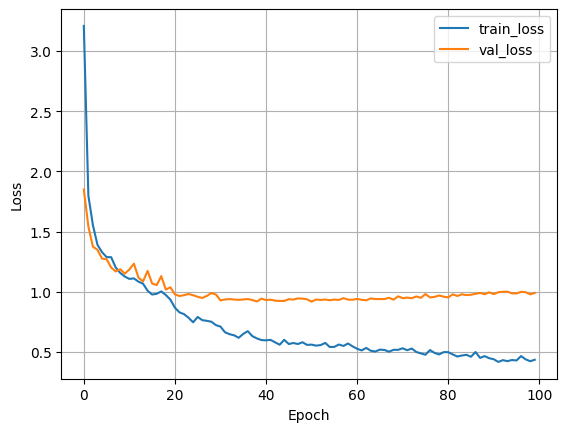

In [28]:
model = Emformer_Classifier(input_dim=256, activation = 'gelu').to('cuda:5')
print(f"Number of parameters: {count_params(model)}")

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40], gamma=0.5)


train_model(model, train_dataloader, val_dataloader, num_epochs=100, num_eval_epoch=1, 
            criterion=None, optimizer=optimizer, scheduler=scheduler, 
            save_dir = "/data/pitch_estimation/Emformer_MIR1k_bs64_gelu", gpu_number = 5)

plot_loss("/data/pitch_estimation/Emformer_MIR1k_bs64_gelu")

In [ ]:
model = Emformer_Classifier(input_dim=256,activation='relu').to('cuda:5')
print(f"Number of parameters: {count_params(model)}")

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

train_model(model, train_dataloader, val_dataloader, num_epochs=80, num_eval_epoch=1, 
            criterion=None, optimizer=optimizer, scheduler=None, 
            save_dir = "/data/pitch_estimation/Emformer_MIR1k", gpu_number = 5)

plot_loss("/data/pitch_estimation/Emformer_MIR1k")

In [ ]:
model = Emformer_Classifier(input_dim=256, num_layers=4).to('cuda:5')
print(f"Number of parameters: {count_params(model)}")

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40], gamma=0.5)


train_model(model, train_dataloader, val_dataloader, num_epochs=50, num_eval_epoch=1, 
            criterion=None, optimizer=optimizer, scheduler=scheduler, 
            save_dir = "/data/pitch_estimation/Emformer_MIR1k_bs64_small", gpu_number = 5)

plot_loss("/data/pitch_estimation/Emformer_MIR1k_bs64_small")

In [ ]:
model = Emformer_Classifier(input_dim=256, num_layers=4).to('cuda:5')
print(f"Number of parameters: {count_params(model)}")

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40], gamma=0.5)


train_model(model, train_dataloader, val_dataloader, num_epochs=50, num_eval_epoch=1, 
            criterion=None, optimizer=optimizer, scheduler=scheduler, 
            save_dir = "/data/pitch_estimation/Emformer_MIR1k_bs64_small", gpu_number = 5)

plot_loss("/data/pitch_estimation/Emformer_MIR1k_bs64_small")

In [ ]:
model = Emformer_Classifier(input_dim=256).to('cuda:5')
print(f"Number of parameters: {count_params(model)}")

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40], gamma=0.5)


train_model(model, train_dataloader, val_dataloader, num_epochs=100, num_eval_epoch=1, 
            criterion=None, optimizer=optimizer, scheduler=scheduler, 
            save_dir = "/data/pitch_estimation/Emformer_MIR1k_bs64", gpu_number = 5)

plot_loss("/data/pitch_estimation/Emformer_MIR1k_bs64")

In [ ]:
min(result['val_loss'])